In [1]:
import argparse
import psycopg2
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import scipy.signal as sg
from allensdk.core.nwb_data_set import NwbDataSet
import pandas as pd
%matplotlib inline

In [2]:
#create pandas dataframe of specimens that have passed QC from the IVSCC log
cells_df =pd.read_csv('speclist.csv')
#generate a custom report in LIMS 'ivscc data status' and save the report
#create another dataframe from that report
LIMS_df = pd.read_csv('custom_report.csv')


In [3]:
#build up all the necessary columns in the cells dataframe
columns = ['Noise_sweeps','depol_sweeps','hyper_sweeps','ss_sweep','ls_sweep','ramp_sweep','full_name','nwb_path','specimen_id','Cre+','Transgenic_Line','ephys_result_id','dendrite_type','depol_threshold', 'hyper_threshold', 'ss_threshold', 'ls_threshold','ramp_threshold_sweep']
for i in columns:
    cells_df[i] = None

In [9]:
#check the dataframe
cells_df.head()

,Labtrax_ID,Noise_sweeps,depol_sweeps,hyper_sweeps,ss_sweep,ls_sweep,ramp_sweep,full_name,nwb_path,specimen_id,Cre+,Transgenic_Line,ephys_result_id,dendrite_type,depol_threshold,hyper_threshold,ss_threshold,ls_threshold,ramp_threshold_sweep
0,165865.05.02,"[37, 38, 39, 40, 41]","[95, 97, 98, 99, 100]","[85, 86, 87, 88, 89, 90, 91, 92]","[11, 12, 13, 14, 15, 16, 17, 18]","[44, 45, 46]","[4, 5, 6]",Sst-IRES-Cre;Ai14-165865.05.02.01,y:/mousecelltypes\prod251\Ephys_Specimen_Roi_p...,464212183,t,Sst-IRES-Cre,464212181,aspiny,None,None,None,None,None
1,165865.03.01,"[37, 38, 39, 40, 41, 42]",None,None,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[35, 36, 44, 45]","[4, 5, 6]",Sst-IRES-Cre;Ai14-165865.03.01.01,y:/mousecelltypes\prod251\Ephys_Specimen_Roi_p...,464198958,t,Sst-IRES-Cre,464198956,aspiny,None,None,None,None,None
2,165171.03.01,[71],None,None,"[17, 18, 19, 20, 21, 22, 23, 24, 25]",[82],"[4, 5]",Pvalb-IRES-Cre;Ai14-165171.03.01.01,y:/mousecelltypes\prod115\Ephys_Specimen_Roi_p...,313862373,t,Pvalb-IRES-Cre,313862370,aspiny,None,None,None,None,None
3,165171.03.02,"[49, 50, 51, 52, 53]","[111, 112, 113, 114, 115, 116, 117, 118, 119]","[103, 104, 105, 106]","[14, 15, 16, 17, 18, 19, 67, 100, 101, 102]","[46, 47]","[4, 5, 6]",Pvalb-IRES-Cre;Ai14-165171.03.02.01,y:/mousecelltypes\prod251\Ephys_Specimen_Roi_p...,464326041,f,Pvalb-IRES-Cre,464326039,aspiny,None,None,None,None,None
4,165172.06.02,"[37, 38, 39, 40, 41, 42]",None,None,[10],[35],"[0, 1]",Pvalb-IRES-Cre;Ai14-165172.06.02.01,y:/mousecelltypes\prod251\Ephys_Specimen_Roi_p...,464326095,t,Pvalb-IRES-Cre,464326093,aspiny,None,None,None,None,None


In [5]:
#create a list to index through
specimen_list = list(cells_df['Labtrax_ID'])

In [6]:
#transfer data from LIMS dataframe to cell dataframe only for cells that have passed QC
for i in range(len(LIMS_df)):
    try:
        j = specimen_list.index(LIMS_df['specimen_name'][i][-15:-3])
        cells_df['Transgenic_Line'][j] = LIMS_df['transgenic_driver_line'][i]
        cells_df['dendrite_type'][j] = LIMS_df['dendrite_type_tag'][i]
        cells_df['Cre+'][j] = LIMS_df['cre_reporter_positive'][i]
        cells_df['ephys_result_id'][j] = LIMS_df['ephys_result_id'][i]
    except ValueError:
        pass

In [7]:
def LinuxtoWindow(Linuxpath):
    SplitLinux = Linuxpath.split('/')
    #I should be able to link to \\titan, but I can't figure it out, so I mapped //titan/cns to y:    
    WindowsP = os.path.join('y:/','mousecelltypes',SplitLinux[4],SplitLinux[5],'')
    #WindowsP = os.path.join('\\titan','cns','mousecelltypes',SplitLinux[4],SplitLinux[5],'')    
    return (WindowsP)

In [8]:
#pull sweep data directly from LIMS
for specimen in range(len(cells_df)):
    conn = psycopg2.connect('host=limsdb2 dbname=lims2 user=limsreader password=limsro')
    cur = conn.cursor()
    spec_name =  cells_df['Labtrax_ID'][specimen].strip() + '.01'
    cur.execute("SELECT s.name, s.ephys_roi_result_id, s.id FROM specimens s WHERE s.name LIKE %s", ('%' + spec_name,))
    result = cur.fetchone()
    if result is None:
        print "Could not find specimen result for " + spec_name + ". Skipping..."
        #return None
    cells_df['full_name'][specimen] = result[0]
    # print "EphysRoiResult: " + str(result[1])
    specimen_name = result[0]
    ephys_roi_result_id = result[1]
    specimen_id = result[2]
    cells_df['specimen_id'][specimen] = specimen_id
    
    cur.execute("SELECT f.filename, f.storage_directory FROM well_known_files f \
                 WHERE f.attachable_type = 'EphysRoiResult' AND f.attachable_id = %s AND f.filename LIKE '%%nwb'", 
                 (ephys_roi_result_id,))
    result = cur.fetchone()

    if result is None:
        print "Could not find orca or nwb file for " + spec_name + ". Skipping..."
        cells_df['nwb_path'][specimen] = None
    WinP = LinuxtoWindow(result[1])
    if result[0][-16:] == 'uncompressed.nwb':
        cells_df['nwb_path'][specimen] = WinP + result[0][:-17]+'.nwb'
    else:
        cells_df['nwb_path'][specimen] = WinP + result[0]
    
    stim_type = ['%%C1RP25PR1S%%','%%C1SSFINEST%%','%%C1LSFINEST%%','%%SEED%%','%%C2SSHM60FN%%','%%C2SSHM80FN%%']
    df_names = ['ramp_sweep','ss_sweep','ls_sweep','Noise_sweeps','depol_sweeps','hyper_sweeps']
    
    for i in range(len(stim_type)):
        cur.execute("SELECT sw.sweep_number FROM ephys_sweeps sw JOIN ephys_stimuli stim \
                    ON stim.id = sw.ephys_stimulus_id\
                    WHERE sw.specimen_id = %s AND stim.description LIKE %s AND sw.workflow_state SIMILAR TO '%%pass%%'", 
                    (specimen_id,stim_type[i],))
        sweep_list = [s[0] for s in cur.fetchall()]

        if not sweep_list:
            cells_df[df_names[i]][specimen] = None
        elif sweep_list[0] is None:
            cells_df[df_names[i]][specimen] = None
        else:
            sweep_list.sort()
            cells_df[df_names[i]][specimen] = sweep_list

In [24]:
def find_threshold(column,i):
    ds =NwbDataSet(cells_df['nwb_path'][i])
    if cells_df[column][i] == None:
        return None
    else:
        sweep_amp = []
        threshold_spike = None
        for j in cells_df[column][i]:
            sweep = ds.get_sweep(j)
            spike_times = ds.get_spike_times(j)
            if len(spike_times) >0:
                if threshold_spike == None:
                    threshold_spike = j
                else:
                    if max(sweep['stimulus']) < max(ds.get_sweep(threshold_spike)['stimulus']):
                        threshold_spike = j
        return threshold_spike

In [26]:
columns = ['depol_sweeps', 'hyper_sweeps', 'ss_sweep', 'ls_sweep']
new_columns = ['depol_threshold', 'hyper_threshold', 'ss_threshold', 'ls_threshold']
for i in range(len(cells_df)):
    for j in range(len(columns)):
        cells_df[new_columns[j]][i] = find_threshold(columns[j],i)

In [11]:
count = 0
for i in range(len(cells_df)):
    if cells_df['depol_sweeps'][i] != None:
        if cells_df['hyper_sweeps'][i] != None:
            count +=1
print count

118


In [ ]:
for i in range(len(cells_df)):
    if cells_df['ramp_sweep'][i] != None:
        for j in cells_df['ramp_sweep'][i]:
            if cells_df['ramp_threshold_sweep'][i] == None:
                ds =NwbDataSet(cells_df['nwb_path'][i])
                sweep = ds.get_sweep(j)
                spike_times = ds.get_spike_times(j)
                if len(spike_times) > 0:
                    cells_df['ramp_threshold_sweep'][i] = j

# how to get cell response from network

In [129]:
ds=NwbDataSet(cells_df['nwb_path'][specimen])
sweep = ds.get_sweep(cells_df['ss_sweep'][specimen][-1])
sweep_i = sweep['response'] *1e3

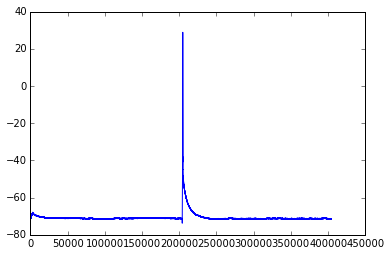

In [130]:
t = np.arange(0, len(sweep_i))
plt.plot(t,sweep_i)

In [131]:
#sweep = ds.get_epyhs_sweeps(cells_df['ss_sweep'][specimen][2])
spike_times = ds.get_spike_times(cells_df['ss_sweep'][specimen][-1])

In [132]:
spike_times

array([ 1.023085])

In [27]:
total = 0
total1=0
for i in range(len(cells_df)):
    if cells_df['Noise_sweeps'][i] != None:  
        if cells_df['ss_sweep'][i] != None:
            if cells_df['ls_sweep'][i] != None:
                if cells_df['ramp_sweep'][i] != None:
                    total +=1
                    for j in cells_df['ramp_sweep'][i]:
                        ds =NwbDataSet(cells_df['nwb_path'][i])
                        sweep = ds.get_sweep(j)
                        spike_times = ds.get_spike_times(j)
                        if len(spike_times) >0:
                            total1 +=1
                            break        

KeyboardInterrupt: 

In [166]:
noise = 0
depol = 0
hyper = 0
ramps = 0
ls = 0
ss = 0
for i in range(len(cells_df)):
    if cells_df['Noise_sweeps'][i] == None:
        pass
    else:
        noise +=1
    if cells_df['depol_sweeps'][i] == None:
        pass
    else:
        depol +=1
    if cells_df['hyper_sweeps'][i] == None:
        pass
    else:
        hyper +=1
    if cells_df['ramp_sweep'][i] == None:
        pass
    else:
        ramps +=1
    if cells_df['ss_sweep'][i] == None:
        pass
    else:
        ss +=1
    if cells_df['ls_sweep'][i] == None:
        pass
    else:
        ls +=1
print noise
print depol
print hyper
print ramps
print ls
print ss

970
172
179
1034
974
1067


In [ ]:
print total
print total1

In [27]:
cells_df.save('showcase_df.pkl')  # where to save it, usually as a .pkl

C:\Anaconda\lib\site-packages\pandas\core\generic.py:968: FutureWarning: save is deprecated, use to_pickle
  warnings.warn("save is deprecated, use to_pickle", FutureWarning)


In [28]:
cells_df.save('showcase_df.h5')

In [ ]:
'''
for i in range(len(cells_df)):
    

In [12]:
cells_df.load('showcase_df.h5')

,Labtrax_ID,Noise_sweeps,depol_sweeps,hyper_sweeps,ss_sweep,ls_sweep,ramp_sweep,full_name,nwb_path,specimen_id,Cre+,Transgenic_Line,ephys_result_id,dendrite_type,depol_threshold,hyper_threshold,ss_threshold,ls_threshold,ramp_threshold_sweep
0,165865.05.02,"[37, 38, 39, 40, 41]","[95, 97, 98, 99, 100]","[85, 86, 87, 88, 89, 90, 91, 92]","[11, 12, 13, 14, 15, 16, 17, 18]","[44, 45, 46]","[4, 5, 6]",Sst-IRES-Cre;Ai14-165865.05.02.01,y:/mousecelltypes\prod251\Ephys_Specimen_Roi_p...,464212183,t,Sst-IRES-Cre,464212181,aspiny,97,88,12,45,4
1,165865.03.01,"[37, 38, 39, 40, 41, 42]",None,None,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[35, 36, 44, 45]","[4, 5, 6]",Sst-IRES-Cre;Ai14-165865.03.01.01,y:/mousecelltypes\prod251\Ephys_Specimen_Roi_p...,464198958,t,Sst-IRES-Cre,464198956,aspiny,None,None,14,35,4
2,165171.03.01,[71],None,None,"[17, 18, 19, 20, 21, 22, 23, 24, 25]",[82],"[4, 5]",Pvalb-IRES-Cre;Ai14-165171.03.01.01,y:/mousecelltypes\prod115\Ephys_Specimen_Roi_p...,313862373,t,Pvalb-IRES-Cre,313862370,aspiny,None,None,17,82,4
3,165171.03.02,"[49, 50, 51, 52, 53]","[111, 112, 113, 114, 115, 116, 117, 118, 119]","[103, 104, 105, 106]","[14, 15, 16, 17, 18, 19, 67, 100, 101, 102]","[46, 47]","[4, 5, 6]",Pvalb-IRES-Cre;Ai14-165171.03.02.01,y:/mousecelltypes\prod251\Ephys_Specimen_Roi_p...,464326041,f,Pvalb-IRES-Cre,464326039,aspiny,114,103,14,47,4
4,165172.06.02,"[37, 38, 39, 40, 41, 42]",None,None,[10],[35],"[0, 1]",Pvalb-IRES-Cre;Ai14-165172.06.02.01,y:/mousecelltypes\prod251\Ephys_Specimen_Roi_p...,464326095,t,Pvalb-IRES-Cre,464326093,aspiny,None,None,10,None,0
5,165874.04.02,"[53, 54, 55, 57, 58]",None,None,"[11, 12, 13, 14, 15, 17, 18, 19, 20, 73, 74, 7...","[50, 51, 52]",[4],Pvalb-IRES-Cre;Ai14-165874.04.02.01,y:/mousecelltypes\prod115\Ephys_Specimen_Roi_p...,313861608,t,Pvalb-IRES-Cre,313861603,aspiny,None,None,80,51,4
6,166229.03.02,"[39, 42]",None,None,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",None,"[4, 5, 6]",Rorb-IRES2-Cre-D;Ai14-166229.03.02.01,y:/mousecelltypes\prod115\Ephys_Specimen_Roi_p...,313861728,f,Rorb-IRES2-Cre,313861725,sparsely spiny,None,None,12,None,4
7,167081.03.02,"[64, 66]",None,None,"[23, 24, 27, 28, 31, 32]",[60],[4],Scnn1a-Tg2-Cre;Ai14-167081.03.02.01,y:/mousecelltypes\prod115\Ephys_Specimen_Roi_p...,313862022,t,Scnn1a-Tg2-Cre,313862020,spiny,None,None,32,60,4
8,167638.05.02,"[42, 43, 44, 45, 46, 47]",None,None,"[14, 15, 16, 17, 18, 19, 20, 21]",None,"[4, 5, 6]",Sst-IRES-Cre;Ai14-167638.05.02.01,y:/mousecelltypes\prod115\Ephys_Specimen_Roi_p...,313862167,t,Sst-IRES-Cre,313862163,aspiny,None,None,15,None,4
9,167636.04.01,"[34, 35, 37]","[91, 92, 93, 94, 95, 96, 97, 98]","[80, 81, 82, 83, 84, 85, 86, 87]","[11, 12, 13, 14, 15, 16, 17, 18]",None,"[4, 5, 6]",Sst-IRES-Cre;Ai14-167636.04.01.01,y:/mousecelltypes\prod115\Ephys_Specimen_Roi_p...,313862306,t,Sst-IRES-Cre,313862304,aspiny,94,83,14,None,4


In [8]:
cells_df = pd.load('showcase_df.h5')

C:\Anaconda\lib\site-packages\pandas\core\common.py:2905: FutureWarning: load is deprecated, use read_pickle
  warnings.warn("load is deprecated, use read_pickle", FutureWarning)


In [10]:
cells_df.tail()

,Labtrax_ID,Noise_sweeps,depol_sweeps,hyper_sweeps,ss_sweep,ls_sweep,ramp_sweep,full_name,nwb_path,specimen_id,Cre+,Transgenic_Line,ephys_result_id,dendrite_type,depol_threshold,hyper_threshold,ss_threshold,ls_threshold
1064,172530.03.02,"[57, 58, 59, 60, 61, 62]",None,None,"[13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 2...",[56],"[4, 5, 6]",Scnn1a-Tg3-Cre;Ai14-172530.03.02.01,y:/mousecelltypes\prod155\Ephys_Specimen_Roi_p...,323838579,None,None,None,None,None,None,16,56
1065,172651.05.01,"[50, 51, 52, 53, 54, 55]","[114, 116, 117, 118, 119, 120, 121]",None,"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...","[57, 58, 59, 60]","[4, 5, 6]",Rorb-IRES2-Cre-D;Ai14-172651.05.01.01,y:/mousecelltypes\prod155\Ephys_Specimen_Roi_p...,324032509,t,Rorb-IRES2-Cre,324032507,spiny,117,None,16,60
1066,172652.05.02,"[63, 64, 65, 66, 68]","[131, 132, 133, 134, 135, 136, 137]",None,"[20, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 3...",None,"[4, 5, 6]",Rorb-IRES2-Cre-D;Ai14-172652.05.02.01,y:/mousecelltypes\prod155\Ephys_Specimen_Roi_p...,324053519,t,Rorb-IRES2-Cre,324053517,spiny,134,None,20,None
1067,172652.03.02,"[42, 45, 46, 47]","[108, 110, 111, 112, 114, 116]","[95, 96, 97, 98, 99, 100, 101, 102, 103, 104]","[11, 12, 13, 14, 15, 16, 17, 18, 19]","[37, 38, 39, 40, 41]","[4, 5, 6]",Rorb-IRES2-Cre-D;Ai14-172652.03.02.01,y:/mousecelltypes\prod155\Ephys_Specimen_Roi_p...,324065524,t,Rorb-IRES2-Cre,324065522,spiny,110,96,11,41
1068,172652.02.02,"[53, 54, 55, 56, 57, 58]",None,None,"[13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 2...",None,[6],Rorb-IRES2-Cre-D;Ai14-172652.02.02.01,y:/mousecelltypes\prod252\Ephys_Specimen_Roi_p...,467003163,t,Rorb-IRES2-Cre,467003016,spiny,None,None,16,None


In [16]:
total = 0
for i in range(len(cells_df)):
    ds =NwbDataSet(cells_df['nwb_path'][i])
    if cells_df['ls_threshold'][i] != None:
        if len(ds.get_spike_times(cells_df['ls_threshold'][i])) > 1:
            total +=1

In [18]:
total

421

In [19]:
trans_line = list(cells_df['Transgenic_Line'])

In [22]:
print np.unique(trans_line)

[None nan nan nan nan nan nan nan nan nan nan nan nan 'Cux2-CreERT2'
 'Gad2-IRES-Cre' 'Htr3a-Cre_NO152' 'Nr5a1-Cre' 'Ntsr1-Cre' 'Pvalb-IRES-Cre'
 'Rbp4-Cre_KL100' 'Rorb-IRES2-Cre' 'Scnn1a-Tg2-Cre' 'Scnn1a-Tg3-Cre'
 'Slc17a6-IRES-Cre' 'Sst-IRES-Cre']


In [26]:
trans_line[2]

'Pvalb-IRES-Cre'